In [1]:
import sys
sys.path.append("/home/salmon/workspace/fytok_tutorial/python")

import typing
import numpy as np
from spdm.view import sp_view

from fytok.utils.logger import logger
from fytok.modules.equilibrium import Equilibrium
from fytok.modules.core_transport import CoreTransport, CoreTransportModel
from fytok.modules.core_profiles import CoreProfiles, CoreProfiles1D

2024-07-23 10:40:52,160 [   fytok]  VERBOSE: Using ontology: imas/3 (dummy) at fytok/mappings/{schema}/imas/3:spdm/mapping/{schema}/imas/3


## Equlibrium

In [2]:
eq = Equilibrium("file+geqdsk://./data/geqdsk.txt#equilibrium")

2024-07-23 10:40:52,357 [   fytok]  VERBOSE: Load module fytok.plugins.modules.equilibrium.fy_eq
2024-07-23 10:40:52,360 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_geqdsk


## CoreProfiles

In [3]:
rho_tor_norm = np.linspace(0.01, 0.95, 128)
core_profiles = CoreProfiles(
    vacuum_toroidal_field={"r0": 5.2, "b0": 2.5},
    profiles_1d={
        "grid": eq.profiles_1d.grid.remesh(rho_tor_norm=rho_tor_norm),
        "ion": ["H", "D"],
    },
)
profiles_1d = core_profiles.profiles_1d

2024-07-23 10:40:52,428 [   fytok]  VERBOSE: Load module spdm.domain.mesh_rectangular


In [4]:
profiles_1d.grid.primary_coordinate

'rho_tor_norm'

In [5]:
from spdm.core.expression import _x

profiles_1d.zeff = np.sqrt(_x) * 2.0
profiles_1d.electrons.density = np.sqrt(_x) * 1.0e19
profiles_1d.electrons.temperature = (_x**2) * 1.0e5
profiles_1d.ion["H"].density = np.sqrt(_x) * 1.0e19
profiles_1d.ion["H"].temperature = (_x**2) * 1.0e5

2024-07-23 10:40:54,262 [   fytok]  VERBOSE: Load module spdm.view.view_matplotlib


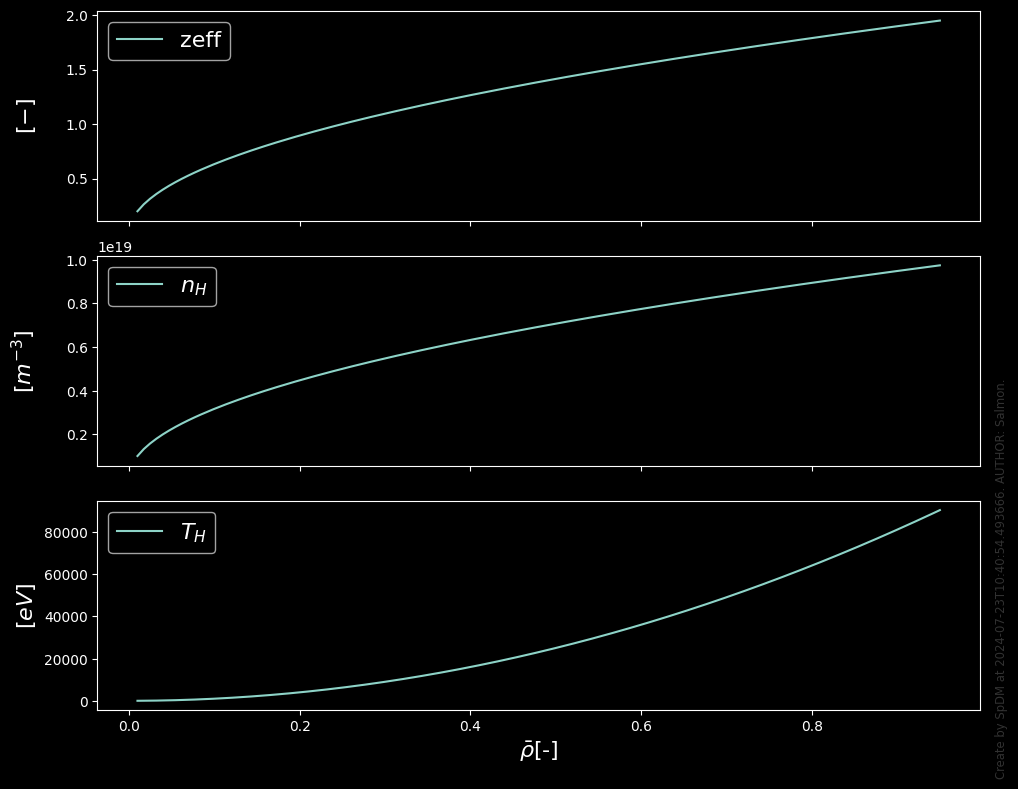

In [6]:
fig = sp_view.plot(
    (profiles_1d.grid.rho_tor_norm, r"$\bar{\rho}$[-]"),
    profiles_1d.zeff,
    (profiles_1d.ion["H"].density, r"$n_H$"),
    (profiles_1d.ion["H"].temperature, r"$T_H$"),
)

## 模块调用

In [7]:
class CoreTransportDemo(CoreTransportModel, code={"name": "demo"}):
    """Plugin Demo: CoreTransportModel"""

    def execute(
        self, *args, equilibrium: Equilibrium, core_profiles: CoreProfiles, **kwargs
    ) -> typing.Self:
        res = super().execute(
            *args,
            equilibrium=equilibrium,
            core_profiles=core_profiles,
            **kwargs,
        )
        res_1d: CoreProfiles.Profiles1D = res.profiles_1d
        eq_1d: Equilibrium.Profiles1D = equilibrium.profiles_1d
        prof_1d: CoreProfiles.Profiles1D = core_profiles.profiles_1d
        psi_norm = res_1d.grid.psi_norm
        rho_tor_norm = res_1d.grid.rho_tor_norm

        res.profiles_1d.conductivity_parallel = np.sin(rho_tor_norm * 6.28)
        return res


spitzer = CoreTransportDemo()

In [8]:
spitzer.refresh(equilibrium=eq, core_profiles=core_profiles)

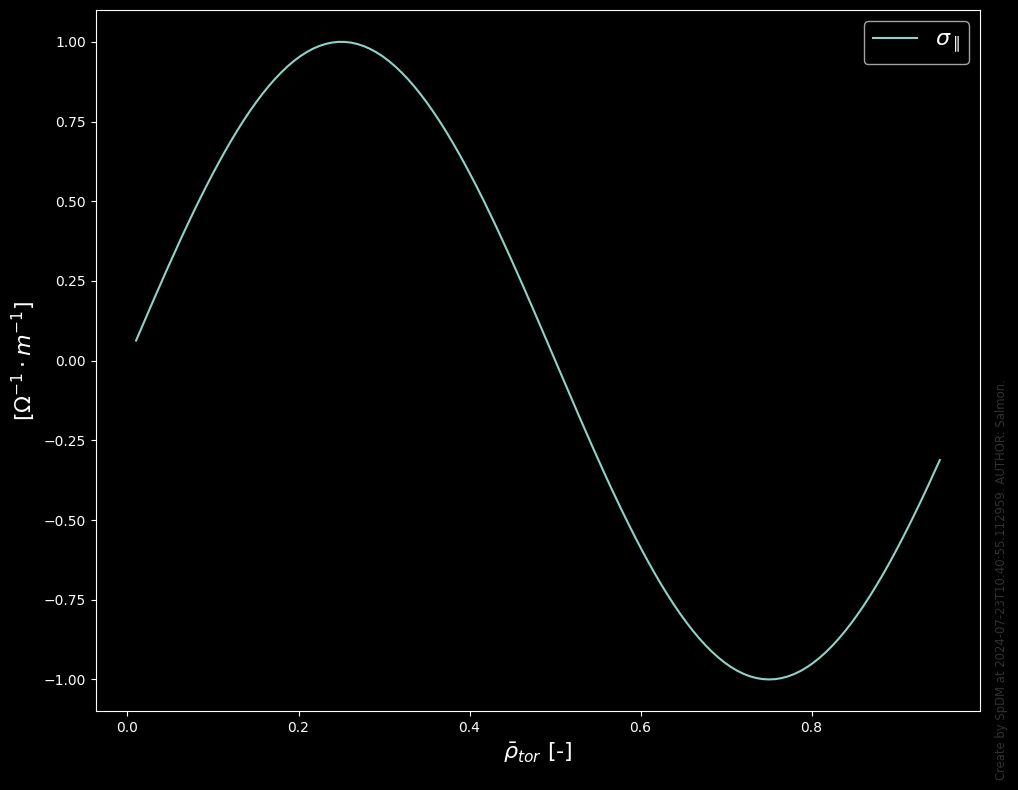

In [9]:
fig=sp_view.plot(spitzer.profiles_1d.rho_tor_norm,spitzer.profiles_1d.conductivity_parallel)

## 插件

In [10]:
model = CoreTransportModel(code={"name": "spitzer_demo"})

2024-07-23 10:40:55,301 [   fytok]  VERBOSE: Load module fytok.plugins.modules.core_transport.model.spitzer_demo


In [11]:
model.refresh(equilibrium=eq, core_profiles=core_profiles)

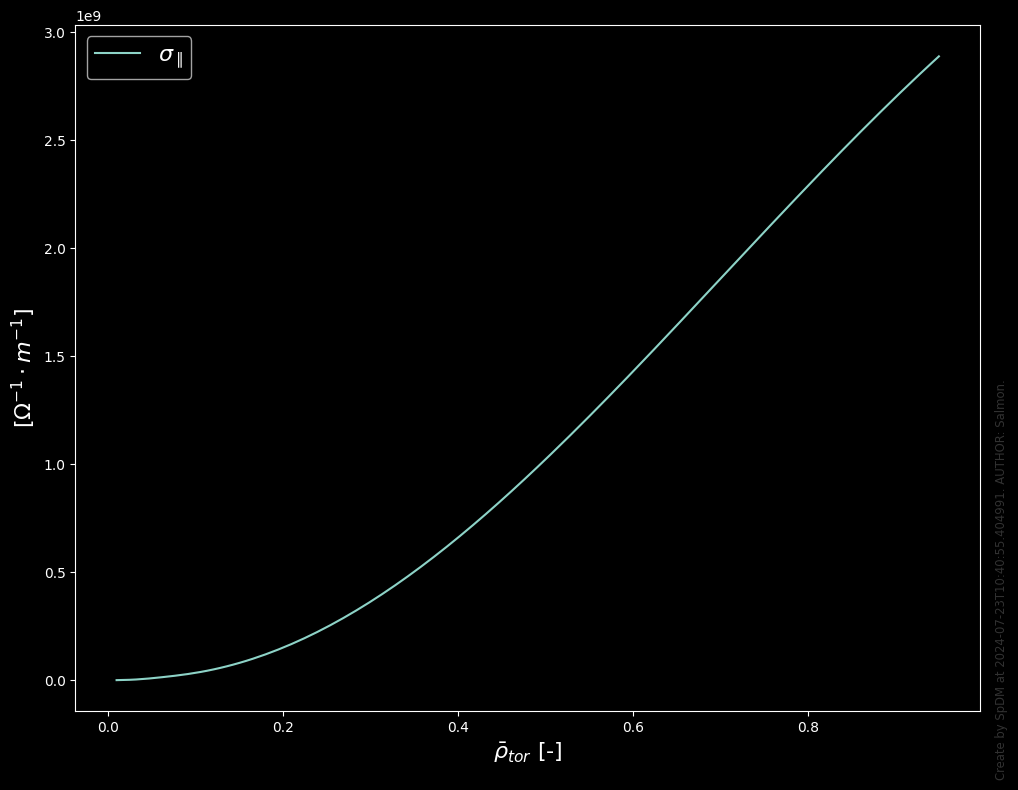

In [12]:
fig=sp_view.plot(model.profiles_1d.rho_tor_norm, model.profiles_1d.conductivity_parallel)